# Import

In [1]:
#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import re

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import random_projection

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

In [5]:
from sklearn.cluster import KMeans

In [6]:
!pip install PyNomaly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for PyNomaly: filename=PyNomaly-0.3.3-py3-none-any.whl size=8498 sha256=8ca2baa5b3d1afc42d325c0d827e863effa2ce0f22b762366a94688e91bdfcdd
  Stored in directory: /root/.cache/pip/wheels/42/29/a3/561def29f8cce748430b2557cbb7e2203116634ee055b29439
Successfully built PyNomaly


In [7]:
import matplotlib.pyplot as plt

In [8]:
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 3.8 MB/s 
     |████████████████████████████████| 281 kB 22.1 MB/s 
     |████████████████████████████████| 1.6 MB 43.6 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=85e4e1b298582b2f59cabe1c9390f3a3410920544663ef124b9110026d3304f6
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [9]:
import swifter

In [10]:
from sklearn import preprocessing

In [11]:
log_path = "drive/MyDrive/GraduateProject/Dataset/Apache.log"

In [12]:
df_log = pd.read_csv(log_path, lineterminator='\n', on_bad_lines='skip', header=None, squeeze=True)

In [13]:
df_log = df_log.str.extract(r"(?P<date>\d{2}) (?P<time>\d{2}\:\d{2}\:\d{2}) (?P<year>\d{4})\] \[(?P<type>\w+)\] (?P<content>.*)", expand=True)

# Implementation

## Function

In [28]:
class LogEvent(object):
    def __init__(self, date_time, warn_type, content) -> None:
        super().__init__()
        self.time = date_time
        self.warn_type = warn_type
        self.proc_content(content)
        self.variable = []
        
    def __str__(self) -> str:
        return "time: %s, type: %s, content: %s" % (self.time, self.warn_type, self.content)

    def proc_content(self, content) -> str:
        self.content = content.strip()
        self.content = re.sub(r"[0-9]+", "", self.content)  # do I need to store this variable?

    def get_content(self) -> str:
        return self.content

    def set_content(self, content):
        self.content = content

    def get_time(self):
        return self.time

    def set_variable(self, variable):
        self.variable.extend(variable)

    def __hash__(self):
        return hash(self.warn_type+self.content)

    def __eq__(self, other): 
        return self.content == other.content and self.warn_type == other.warn_type

In [29]:
def clean_data_2ed(data):
    logs = []
    token_specification = [
                ("date_time", r"\[(Mon|Tue|Wed|Thu|Fri|Sat|Sun)[^\]]*\]"),
                ("warn_type", r"\[\S*\]"),
                ("content", r"[^\]]*?(\n|\r)"),
    ]
    tok_regex = '.*?'.join('(?P<%s>%s)' % pair for pair in token_specification)
    for i in range(len(data)):
        for mo in re.finditer(tok_regex, data[i]):
            event = LogEvent(**mo.groupdict())
        if len(logs) != 0:
            if event != logs[-1]:
                logs.append(event)
        else:
            logs.append(event)
    return logs

In [30]:
"""
This function is aim to generate a n-gram array for each sentense.
"""
def generate_n_gram(data, ngram=1):
    terms = []
    for idx in range(len(data)):
        try:
            words = data[idx].strip().split()
            temp = zip(*[words[i:] for i in range(0, ngram)])
            temp = [' '.join(ngram) for ngram in temp]
            data[idx] = temp
            terms.extend(temp)
        except Exception:
            continue
            # print(data[idx])
    terms_list = set(terms)
    return data, terms_list

In [31]:
"""
This function is aim to generate n-gram/words frequency matrix.
"""
def generate_frequency_matrix(data, terms):
    matrix = pd.DataFrame(columns=terms)
    for idx in range(len(data)):
        freq = dict()
        for w in data[idx]:
            if w not in freq:
                freq[w] = 1
            else:
                freq[w] += 1
        matrix = matrix.append(freq, ignore_index=True)
    matrix = matrix.fillna(0)
    return matrix

In [32]:
def terms_sum(data):
    terms = dict()
    for i in range(len(data)):
        for w in data[i]:
            if w not in terms:
                terms[w] = 1
            else:
                terms[w] += 1
    return terms

In [33]:
def terms_position_freq(data):
    max_len = max(len(i) for i in data)
    terms = dict()
    for idx in range(len(data)):
        for idx_w in range(len(data[idx])):
            if data[idx][idx_w] not in terms:
                terms[data[idx][idx_w]] = [0] * max_len
            terms[data[idx][idx_w]][idx_w] += 1
    return terms

In [34]:
import math
def get_variable(data, terms_freq):
    removed = []
    for idx in range(len(data)):
        tmp_freq = []
        for idx_w in range(len(data[idx])):
            tmp_freq.append(terms_freq[data[idx][idx_w]][idx_w])
        # find the most frequent word and set it as the min frequency for a log
        try:
            min_freq = get_cluster_min(tmp_freq)
            row = 0
            for idx_w in range(len(tmp_freq)):
                if tmp_freq[idx_w] < min_freq:
                    removed.append(data[idx][idx_w])
                    row += 1
            if row == 0:
                print(tmp_freq)
        except Exception:
            continue
    return set(removed)

In [35]:
def remove_var(row, terms_freq):
    con = row["content"].strip().split()

    new_con = []
    tmp_freq = []
    for idx_w in range(len(con)):
        tmp_freq.append(terms_freq[con[idx_w]][idx_w])
    # find the most frequent word 
    # and set it as the min frequency for a log
    try:
        min_freq = get_cluster_min(tmp_freq)
        flag = 0
        for idx_w in range(len(tmp_freq)):
            if tmp_freq[idx_w] >= min_freq:
                new_con.append(con[idx_w])
                flag += 1
        if flag == 0:
            print(tmp_freq)
        row["event"] = " ".join(new_con)
    except Exception as e:
        # 大多是空数组或者元素全部一样的数组导致的
        # print(e)
        # print(tmp_freq)
        row["event"] = " ".join(con)
    return row

In [36]:
from numpy import random
def set_constant(events, tok):
    log_pattern = []
    for idx in range((len(events))):
        content = events[idx].get_content().strip("*- ./").split()
        content = " ".join([i for i in content if i in tok])
        # if random.random() > 0.8:
        #     print(content)
        # devide variable part
        
        log_pattern.append(content)
        events[idx].content = content
    return set(log_pattern)

In [37]:
"""
用kernel density estimation算法来取得数组的'聚类'
用scipy.signal.argrelextrema获取局部极值
"""
def get_cluster_min(arr):
    arr = np.array(arr).reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian').fit(arr)
    s = np.linspace(0, np.max(arr))
    e = kde.score_samples(s.reshape(-1,1))
    mi = argrelextrema(e, np.less)[0]
    return s[mi][0]

In [38]:
from sklearn.decomposition import PCA
from sklearn import random_projection

def decompostion(data, method="pca", n_com=0.8):
    if method == "pca":
        pca = PCA(n_com)
        df = pca.fit_transform(data)
    elif method == "rp":
        # Use The Johnson-Lindenstrauss lemma
        df = random_projection.johnson_lindenstrauss_min_dim(n_samples=data)
    else:
        print("pca/rp")
    return df

In [39]:
def log_simi(s1, s2, bar=0.95):
    s1 = set(s1.split())
    s2 = set(s2.split())
    if s1 and s2:
        return len(s1 & s2) / len(s1 | s2)
    else:
        return 0

In [40]:
def combine_events(events):
    # store the previous similar log.
    event_root = dict()
    for i in events.keys():
        event_root[i] = None

    keys = list(events.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            if log_simi(events[keys[i]], events[keys[j]]) >= 0.95:
                event_root[keys[j]] = keys[i]

    return event_root

In [41]:
def get_log_weight(data, events):
    n = len(data)
    weight = {}
    col = data.columns
    for i in events:
        if i in col:
            ni = data[i].sum()
            if ni == 0:
                weight[i] = 0  # 这个事件没有出现过
            else:
                weight[i] = np.log(n/ni)
    return weight

## Read Data to DF

In [42]:
hdfs_y = pd.read_csv("drive/MyDrive/GraduateProject/Dataset/HDFS_1/anomaly_label.csv")

In [ ]:
hdfs_y = hdfs_y.set_index("BlockId")

In [43]:
hdfs_log = pd.read_csv("drive/MyDrive/GraduateProject/Dataset/HDFS_1/HDFS.log", lineterminator='\n', on_bad_lines='skip', header=None, squeeze=True)

In [44]:
hdfs_log = hdfs_log.str.extract(r"(?P<content>.*(?P<blk_num>blk_\S+).*)", expand=True)

In [45]:
type(hdfs_log)

pandas.core.frame.DataFrame

In [ ]:
len(hdfs_log.groupby("blk_num"))

580406

In [ ]:
groups_num = np.random.choice(hdfs_log["blk_num"].unique(), int(len(hdfs_log) * 0.001))
hdfs_log = hdfs_log.set_index("blk_num").loc[groups_num]

In [ ]:
len(hdfs_log)

215347

In [ ]:
hdfs_log = pd.merge(hdfs_log, hdfs_y, left_index=True, right_index=True)

In [ ]:
hdfs_log

,content,Label
blk_-1002473978927694046,081109 213211 2304 INFO dfs.DataNode$DataXceiv...,Normal
blk_-1002473978927694046,081109 213211 2316 INFO dfs.DataNode$DataXceiv...,Normal
blk_-1002473978927694046,081109 213211 2325 INFO dfs.DataNode$DataXceiv...,Normal
blk_-1002473978927694046,081109 213211 27 INFO dfs.FSNamesystem: BLOCK*...,Normal
blk_-1002473978927694046,081109 213248 2305 INFO dfs.DataNode$PacketRes...,Normal
...,...,...
blk_996984424698507131,081111 084504 24846 INFO dfs.DataNode$PacketRe...,Normal
blk_996984424698507131,081111 084504 24846 INFO dfs.DataNode$PacketRe...,Normal
blk_996984424698507131,081111 084504 28 INFO dfs.FSNamesystem: BLOCK*...,Normal
blk_996984424698507131,081111 084504 30 INFO dfs.FSNamesystem: BLOCK*...,Normal


## Extract Events

In [ ]:
# 计算时间
import datetime
ct = datetime.datetime.now()

In [ ]:
cons = hdfs_log["content"].tolist()
cons, tok = generate_n_gram(cons, 1)

terms_freq = terms_position_freq(cons)

In [ ]:
hdfs_log = hdfs_log.swifter.apply(remove_var, terms_freq=terms_freq, axis=1)

/usr/local/lib/python3.7/dist-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


Pandas Apply:   0%|          | 0/215232 [00:00<?, ?it/s]

In [ ]:
hdfs_log["event"] = hdfs_log["event"].str.replace("\d", "", regex=True)
hdfs_log["event"] = hdfs_log["event"].str.replace("[-()\"#/@;:<>{}`+=~|.!?,]", "", regex=True)
hdfs_log["event"] = hdfs_log["event"].str.replace(" +", " ", regex=True)
hdfs_log["event"] = hdfs_log["event"].str.strip()

In [ ]:
hdfs_log = hdfs_log[hdfs_log["event"] != ""]

In [ ]:
hdfs_log["event"] = pd.Categorical(hdfs_log["event"])
hdfs_event = dict(enumerate(hdfs_log["event"].cat.categories))

In [ ]:
hdfs_log["event"] = hdfs_log["event"].cat.codes

In [ ]:
hdfs_log.index.name = "blk_num"

In [ ]:
hdfs_log = hdfs_log.reset_index().drop_duplicates(["blk_num", "event"]).set_index("blk_num")

In [ ]:
# for i in range(len(hdfs_event.keys())):
#     print(f"E{i}\t{hdfs_event[i]}")

In [ ]:
train_blk, test_blk = train_test_split(hdfs_log.index.unique(), test_size=0.2)

In [ ]:
test_log = hdfs_log.loc[test_blk]
hdfs_log = hdfs_log.loc[train_blk]

## Sequences Matrix with IDF weight

In [ ]:
ct = datetime.datetime.now()

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
hdfs_dum = pd.get_dummies(hdfs_log["event"])

In [ ]:
hdfs_freq = hdfs_dum.groupby("blk_num").sum()

In [ ]:
# hdfs_freq = hdfs_freq[hdfs_event.keys()]

In [ ]:
hdfs_log_w = get_log_weight(hdfs_freq, hdfs_event)

In [ ]:
hdfs_freq

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
blk_num,,,,,,,,,,,,,,,,,,,,,
blk_-1002473978927694046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.209386,0.000000,0.00000,0.000000,0.0,0.000000
blk_-100316991987178453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.209386,0.000000,0.00000,0.000000,0.0,0.000000
blk_-1004493839188035740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.445836,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.209386,1.926154,0.00000,1.505161,0.0,0.000000
blk_-1007349269840587831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000
blk_-10080244440394751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.209386,0.000000,0.00000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blk_992101295951175683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.445836,0.0,0.0,...,4.568347,0.010084,0.0,0.0,0.209386,0.000000,4.59057,0.000000,0.0,9.079206
blk_993215730547027823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.209386,0.000000,0.00000,0.000000,0.0,0.000000
blk_993284403351741010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.010084,0.0,0.0,0.209386,0.000000,0.00000,0.000000,0.0,0.000000


In [ ]:
for i in hdfs_log_w.keys():
    hdfs_freq[[i]] = hdfs_freq[[i]] * hdfs_log_w[i]

In [ ]:
hdfs_nor_freq = scaler.fit_transform(hdfs_freq)

In [ ]:
print("spent time: ", datetime.datetime.now() - ct)

spent time:  0:00:00.579700


In [ ]:
hdfs_nor_freq

array([[-0.01508586, -0.02385691, -0.09523126, ..., -0.09400728,
        -0.53252835, -0.04529883],
       [-0.01508586, -0.02385691, -0.09523126, ..., -0.09400728,
        -0.53252835, -0.04529883],
       [-0.01508586, -0.02385691, -0.09523126, ..., -0.09400728,
        -0.53252835, -0.04529883],
       ...,
       [-0.01508586, -0.02385691, -0.09523126, ..., -0.09400728,
        -0.53252835, -0.04529883],
       [-0.01508586, -0.02385691, -0.09523126, ..., -0.09400728,
        -0.53252835, -0.04529883],
       [-0.01508586, -0.02385691, -0.09523126, ..., -0.09400728,
         1.87783428, -0.04529883]])

In [ ]:
len(hdfs_dum)

63810

In [ ]:
pd.merge(hdfs_dum.groupby("blk_num").sum().drop_duplicates(), hdfs_y, left_index=True, right_index=True)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Label
blk_-1002960687818687437,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,0,Normal
blk_-1007239912653570146,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,Normal
blk_-1010346678631629347,0,0,0,0,0,0,1,1,0,0,...,0,1,0,1,1,1,0,1,0,Normal
blk_-1022721217436729892,0,0,0,0,0,0,1,1,0,0,...,0,1,0,1,1,0,0,1,0,Normal
blk_-1044256090636118902,0,0,0,0,0,0,1,1,0,0,...,0,1,0,1,1,1,0,0,0,Normal
blk_-1056291813689378781,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,1,0,0,0,Normal
blk_-1192825953645039677,0,0,1,0,0,1,1,1,0,0,...,1,1,0,1,1,1,1,1,0,Normal
blk_-1311976739916489373,0,0,1,0,0,1,1,0,0,0,...,1,1,0,1,0,0,1,0,0,Normal
blk_-1404877373696450819,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,Anomaly
blk_-1436417257306264989,0,0,0,0,0,0,1,1,0,0,...,0,1,0,1,1,0,0,0,0,Normal


## Agglomerative Clustering(V)

In [ ]:
tmp = pd.merge(hdfs_dum.groupby("blk_num").sum(), hdfs_y, left_index=True, right_index=True)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

agg_clu = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5).fit(hdfs_nor_freq)
label_pred = agg_clu.labels_

In [ ]:
print(agg_clu.n_clusters_)

31


In [ ]:
len(label_pred)

8787

In [ ]:
hdfs_event

{0: 'INFO',
 1: 'INFO Receiving',
 2: 'INFO block',
 3: 'INFO dfsDataNode$DataXceiver',
 4: 'INFO dfsDataNode$DataXceiver Received block src dest of',
 5: 'INFO dfsDataNode$DataXceiver Receiving block src dest',
 6: 'INFO dfsDataNode$DataXceiver Served block to',
 7: 'INFO dfsDataNode$PacketResponder PacketResponder',
 8: 'INFO dfsDataNode$PacketResponder PacketResponder for block',
 9: 'INFO dfsDataNode$PacketResponder PacketResponder for block terminating',
 10: 'INFO dfsDataNode$PacketResponder Received block of size from',
 11: 'INFO dfsFSDataset Deleting block file',
 12: 'INFO dfsFSNamesystem BLOCK*',
 13: 'INFO dfsFSNamesystem BLOCK* NameSystemaddStoredBlock blockMap updated is added to size',
 14: 'INFO dfsFSNamesystem BLOCK* NameSystemaddStoredBlock size',
 15: 'INFO dfsFSNamesystem BLOCK* NameSystemallocateBlock',
 16: 'INFO dfsFSNamesystem BLOCK* NameSystemdelete is added to invalidSet of',
 17: 'INFO for',
 18: 'INFO to',
 19: 'WARN dfsDataNode$DataXceiver exception while s

In [ ]:
label_center = {}
for i in range(agg_clu.n_clusters_):
    _ = tmp[label_pred == i]
    # calculate the center
    mean = _.mean()
    seq = []
    for j in range(len(mean)):
        if mean[j] != 0:
            seq.append(f"E{j}")
    print(f"Seq{i}\t{'-'.join(seq)}")
    label_center[i] = hdfs_nor_freq[label_pred == i].mean(axis=0)

Seq0	E5-E9-E10-E11-E13-E15-E16-E20
Seq1	E5-E9-E10-E13-E15-E20
Seq2	E2-E4-E5-E9-E10-E11-E12-E13-E15-E17-E18
Seq3	E2-E4-E5-E9-E10-E11-E12-E13-E15-E18
Seq4	E2-E4-E5-E6-E9-E10-E11-E12-E13-E15-E16-E17-E18-E19
Seq5	E2-E4-E5-E9-E10-E11-E12-E13-E15-E16-E17-E18
Seq6	E5-E6-E9-E10-E11-E13-E15-E16-E19
Seq7	E5-E9-E10-E11-E13-E15-E16-E17
Seq8	E2-E4-E5-E9-E10-E11-E12-E13-E15-E16-E18
Seq9	E0-E3-E5-E7-E9-E15
Seq10	E2-E4-E5-E6-E9-E10-E11-E12-E13-E15-E16-E18
Seq11	E3-E5-E15
Seq12	E2-E4-E5-E6-E9-E10-E11-E12-E13-E15-E16-E18-E19
Seq13	E5-E9-E10-E13-E15
Seq14	E5-E6-E9-E10-E11-E13-E15-E16
Seq15	E5-E6-E9-E10-E11-E12-E13-E15-E16-E18-E19
Seq16	E5-E9-E10-E11-E13-E15-E16
Seq17	E5-E9-E10-E13-E15-E17
Seq18	E5-E6-E9-E10-E11-E13-E15-E16-E17
Seq19	E5-E9-E10-E11-E13-E14-E15-E16
Seq20	E5-E6-E9-E10-E11-E13-E14-E15-E16-E19
Seq21	E0-E3-E5-E7-E8-E9-E15
Seq22	E1-E5-E9-E10-E11-E13-E15-E16
Seq23	E5-E6-E9-E10-E11-E13-E15-E16-E19-E20
Seq24	E5-E6-E9-E10-E11-E13-E14-E15-E16-E17-E19
Seq25	E5-E15
Seq26	E5-E6-E9-E10-E11-E13-E15-E16-E1

In [ ]:
# Calculate the abnormal rate in each cluster
print("Cluster\tNormal Data\tLabel")
cluster_label = {}
for i in range(agg_clu.n_clusters_):
    aa = tmp.loc[tmp[label_pred == i].index.values]
    nor_rate = len(aa[aa['Label'] == 'Normal'])/len(aa)
    if nor_rate > 0.9:
        cluster_label[i] = "Normal"
    else:
        cluster_label[i] = "Anomaly"
    print(f"Cluster{i}\t{'%.2f'%nor_rate}\t{cluster_label[i]}")

Cluster	Normal Data	Label
Cluster0	0.00	Anomaly
Cluster1	0.00	Anomaly
Cluster2	1.00	Normal
Cluster3	1.00	Normal
Cluster4	0.11	Anomaly
Cluster5	0.00	Anomaly
Cluster6	0.99	Normal
Cluster7	0.99	Normal
Cluster8	0.00	Anomaly
Cluster9	0.00	Anomaly
Cluster10	0.00	Anomaly
Cluster11	0.00	Anomaly
Cluster12	0.00	Anomaly
Cluster13	1.00	Normal
Cluster14	1.00	Normal
Cluster15	1.00	Normal
Cluster16	0.99	Normal
Cluster17	1.00	Normal
Cluster18	1.00	Normal
Cluster19	0.00	Anomaly
Cluster20	0.00	Anomaly
Cluster21	0.00	Anomaly
Cluster22	0.00	Anomaly
Cluster23	0.00	Anomaly
Cluster24	0.00	Anomaly
Cluster25	0.00	Anomaly
Cluster26	0.99	Normal
Cluster27	0.00	Anomaly
Cluster28	0.00	Anomaly
Cluster29	0.00	Anomaly
Cluster30	0.00	Anomaly


## Predict

In [ ]:
test_freq = pd.get_dummies(test_log["event"]).groupby("blk_num").sum()

In [ ]:
for i in hdfs_log_w.keys():
    if i not in test_freq.columns:
        test_freq[i] = 0
    else:
        test_freq[i] = test_freq[i] * hdfs_log_w[i]

In [ ]:
# 重新排列列的顺序
test_freq = test_freq[hdfs_dum.columns]

In [ ]:
test_freq = pd.DataFrame(scaler.transform(test_freq), index=test_freq.index)

In [ ]:
test_freq

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
blk_num,,,,,,,,,,,,,,,,,,,,,
blk_-1000324420442690269,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,1.756979,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,2.436243,-0.092158,1.833247,-0.03698
blk_-1001016691198895972,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,1.756979,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,1.833247,-0.03698
blk_-1008202429000899029,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,1.756979,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,2.436243,-0.092158,1.833247,-0.03698
blk_-1043808212660255962,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,-0.545480,-0.03698
blk_-1050427428783465714,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,-0.545480,-0.03698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blk_973987321385246274,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,-0.545480,-0.03698
blk_985783095807348907,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,-0.545480,-0.03698
blk_992114084240165364,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.476871,-0.092158,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,-0.545480,-0.03698


In [ ]:
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

def get_cluster(row, cluster_center):
    # dis = 0.5
    min_dis = 100
    clu = -1
    for i in cluster_center.keys():
        # calculate the distance between current row and cluster center
        tmp = np.linalg.norm(row - label_center[i])
        if tmp < min_dis:
            min_dis = tmp
            clu = i
    # if min_dis > dis:
    #     clu = "new"
    # print(min_dis)
    row["cluster"] = clu
    return row

In [ ]:
label_center[1]

array([-2.13406948e-02, -2.38609805e-02, -9.15277217e-02, -8.22183273e-02,
       -9.15277217e-02,  0.00000000e+00, -5.69158625e-01, -2.13406948e-02,
       -1.50884322e-02,  1.09441433e-01,  1.11551916e-01, -2.09700266e+00,
       -9.21577797e-02,  1.11551916e-01, -4.13519808e-02,  0.00000000e+00,
       -2.07590114e+00, -4.10468077e-01, -9.21577797e-02, -5.45480275e-01,
        2.70416346e+01])

In [ ]:
# 判断test数据中的每一行属于哪个集群
pred_cluster = test_freq.drop_duplicates().swifter.apply(get_cluster, cluster_center=label_center, axis=1)

Pandas Apply:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
pd.merge(pred_cluster, hdfs_y,left_on=None, right_on=None, left_index=True, right_index=True)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,cluster,Label
blk_-1000324420442690269,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,1.756979,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,0.481719,2.436243,-0.092158,1.833247,-0.036980,26.0,Normal
blk_-1001016691198895972,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,1.756979,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,1.833247,-0.036980,6.0,Normal
blk_-1043808212660255962,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,0.481719,-0.410468,-0.092158,-0.545480,-0.036980,16.0,Normal
blk_-1067682255435160182,-0.021341,-0.023861,10.925652,-0.082218,10.925652,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,0.481719,-0.410468,10.850956,-0.545480,-0.036980,8.0,Anomaly
blk_-1083797098990245989,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,0.481719,2.436243,-0.092158,-0.545480,-0.036980,7.0,Normal
blk_-1128879792823377616,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,-2.075901,-0.410468,-0.092158,-0.545480,-0.036980,13.0,Normal
blk_-1303355063504307925,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,-9.137307,...,-8.964436,-0.041352,0.0,-2.075901,-0.410468,-0.092158,-0.545480,-0.036980,25.0,Anomaly
blk_-1316005228433438186,-0.021341,-0.023861,-0.091528,-0.082218,-0.091528,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,-2.075901,2.436243,-0.092158,-0.545480,-0.036980,17.0,Normal
blk_-1918609342415438748,-0.021341,-0.023861,-0.091528,12.162738,-0.091528,0.0,-0.569159,-0.021341,-0.015088,-9.137307,...,-8.964436,-0.041352,0.0,-2.075901,-0.410468,-0.092158,-0.545480,-0.036980,11.0,Anomaly
blk_-1933944024377781654,-0.021341,-0.023861,10.925652,-0.082218,10.925652,0.0,-0.569159,-0.021341,-0.015088,0.109441,...,0.111552,-0.041352,0.0,-2.075901,-0.410468,10.850956,-0.545480,-0.036980,3.0,Normal


## Evaluation

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(hdfs_nor_freq, label_pred)

0.9994309768964299

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(hdfs_nor_freq, label_pred)

9.794870342091874e-08

## K-Means(X)

In [ ]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += np.linalg.norm(curr_center - points[i])
      
    sse.append(curr_sse)
  return sse

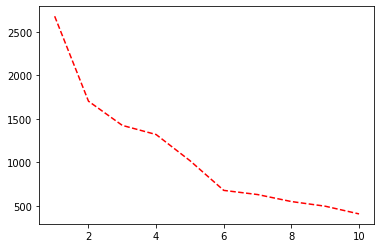

In [ ]:
wss = calculate_WSS(hdfs_freq, 10)
plt.plot([i for i in range(1, 11)], wss, 'r--')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def k_means_plot(points, k=2):
    kmeans = KMeans(n_clusters = k).fit(points)
    label_pred = kmeans.labels_
    new_data = decompostion(points, n_com=2)
    color = ["red", "black", "pink", "blue", "yellow"]
    for i in range(k):
        label = new_data[label_pred == i]
        plt.scatter(label[:,0] , label[:,1] , color = color[i])
    plt.show()

    return label_pred

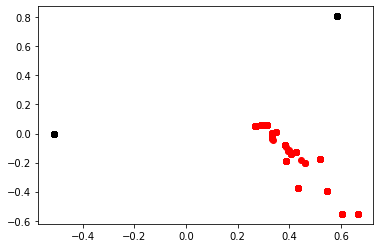

In [ ]:
hdfs_label = k_means_plot(hdfs_nor_freq, 2)

In [ ]:
pd.merge(hdfs_freq[hdfs_label == 0], hdfs_y, left_index=True, right_index=True).drop_duplicates()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Label
blk_-1006684510512952277,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.443169,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.215115,1.948738,0.000000,1.505627,0.000000,Normal
blk_-1010306386279704106,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.443169,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.215115,0.000000,0.000000,1.505627,0.000000,Normal
blk_-1017453146862072685,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.443169,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.215115,0.000000,0.000000,0.000000,6.818833,Anomaly
blk_-1025005661735286473,0.00000,0.000000,0.000000,4.973006,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Anomaly
blk_-1044256090636118902,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.443169,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.215115,1.948738,0.000000,0.000000,0.000000,Normal
blk_-1046395723006685833,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.215115,1.948738,0.000000,0.000000,0.000000,Normal
blk_-1063374971662716381,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.000000,1.948738,0.000000,0.000000,0.000000,Normal
blk_-1085330061867061952,0.00000,0.000000,4.594209,0.000000,4.594209,0.0,0.000000,0.00000,0.011635,0.011727,...,4.594209,0.011727,0.000000,0.0,0.215115,0.000000,4.594209,0.000000,0.000000,Anomaly
blk_-115239807422414213,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.443169,0.00000,0.011635,0.011727,...,0.000000,0.011727,0.000000,0.0,0.215115,0.000000,0.000000,0.000000,0.000000,Normal
blk_-1597996193363919220,0.00000,0.000000,4.594209,0.000000,4.594209,0.0,0.000000,0.00000,0.011635,0.011727,...,4.594209,0.011727,0.000000,0.0,0.000000,0.000000,4.594209,0.000000,0.000000,Normal


# Implementation-2

In [ ]:
apache_log = pd.read_csv("drive/MyDrive/GraduateProject/Dataset/Apache.log", lineterminator='\n', on_bad_lines='skip', header=None, squeeze=True)

In [ ]:
apache_log = apache_log.str.extract(r"\[(?P<datetime>.*?20[0-9]{2})\] \[(?P<type>\w+)\] (?P<client>\[.*?\])?(?P<content>.*)", expand=True)

In [ ]:
apache_log[["datetime", "type", "content"]]

,datetime,type,content
0,Thu Jun 09 06:07:04 2005,notice,LDAP: Built with OpenLDAP LDAP SDK
1,Thu Jun 09 06:07:04 2005,notice,LDAP: SSL support unavailable
2,Thu Jun 09 06:07:04 2005,notice,suEXEC mechanism enabled (wrapper: /usr/sbin/s...
3,Thu Jun 09 06:07:05 2005,notice,Digest: generating secret for digest authentic...
4,Thu Jun 09 06:07:05 2005,notice,Digest: done
...,...,...,...
56091,Mon Feb 27 21:56:11 2006,error,Directory index forbidden by rule: /var/www/h...
56092,Tue Feb 28 00:45:58 2006,error,Directory index forbidden by rule: /var/www/h...
56093,Tue Feb 28 00:46:47 2006,error,Directory index forbidden by rule: /var/www/h...
56094,Tue Feb 28 03:04:53 2006,error,Directory index forbidden by rule: /var/www/h...


In [ ]:
apache_log["datetime"] = pd.to_datetime(apache_log["datetime"])

In [ ]:
apache_log["content"] = apache_log["content"].fillna("")

In [ ]:
apa_cons = apache_log["content"].tolist()
apa_cons, df_tok = generate_n_gram(apa_cons, 1)

apa_terms_freq = terms_position_freq(apa_cons)

In [ ]:
apache_log = apache_log.swifter.apply(remove_var, terms_freq=apa_terms_freq, axis=1)

Pandas Apply:   0%|          | 0/56096 [00:00<?, ?it/s]

In [ ]:
apache_log["event"] = apache_log["event"].str.replace("\d", "", regex=True)

In [ ]:
apache_log["event"] = apache_log["event"].str.strip()

In [ ]:
len(set(apache_log["event"]))

24

In [ ]:
apache_log = apache_log.set_index("datetime")

In [ ]:
apache_log = apache_log.reset_index()

In [ ]:
apache_log["datetime"] = apache_log["datetime"].dt.strftime("%Y-%d-%m %H:00:00")

In [ ]:
apache_log["event"] = pd.Categorical(apache_log["event"])
apa_event = dict(enumerate(apache_log["event"].cat.categories))

In [ ]:
apa_event

{0: 'Apache/.. (Fedora) configured -- resuming normal operations',
 1: 'Digest:',
 2: 'Directory index forbidden by rule: /var/www/html/',
 3: 'File does not exist:',
 4: 'Invalid in request',
 5: 'Invalid method in request get',
 6: 'LDAP:',
 7: 'attempt to invoke directory as script: /var/www/cgi-bin/',
 8: "config.update(): Can't create",
 9: "jk_init() Can't find child in scoreboard",
 10: 'jk_init() Found child in scoreboard slot',
 11: 'mod_jk Shutting down',
 12: 'mod_jk child init',
 13: 'mod_jk child workerEnv in error state',
 14: 'mod_python: Creating  session mutexes based on  max processes and  max threads.',
 15: 'mod_security/.dev configured',
 16: 'request',
 17: 'request failed:',
 18: 'script not found or unable to stat:',
 19: 'suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)',
 20: 'to',
 21: 'uriMap.mapUri() uri must start with /',
 22: 'workerEnv.init() ok /etc/httpd/conf/workers.properties'}

In [ ]:
apache_log["event"] = apache_log["event"].cat.codes

In [ ]:
apache_log = apache_log.drop_duplicates(["datetime", "event"])

In [ ]:
apa_dum = pd.get_dummies(apache_log.set_index("datetime").event)

In [ ]:
apa_freq = apa_dum.groupby("datetime").sum()

In [ ]:
apa_log_w = get_log_weight(apa_freq, apa_event)

In [ ]:
for i in apa_log_w.keys():
    apa_freq[[i]] = apa_freq[[i]] * apa_log_w[i]

In [ ]:
apa_nor_freq = preprocessing.normalize(apa_freq)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

apa_agg_clu = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5).fit(apa_nor_freq)
apa_label_pred = apa_agg_clu.labels_

In [ ]:
for i in range(apa_agg_clu.n_clusters_):
    pp = apa_freq[apa_label_pred == i].mean()
    apa_seq = []
    for j in apa_event.keys():
        if pp[j] > 0:
            apa_seq.append(f"E{j}")
    print(f"Seq{i}\t{'-'.join(apa_seq)}")

Seq0	E2-E3
Seq1	E2-E3-E9-E10-E12-E18-E22
Seq2	E2-E3-E10-E11-E12-E13-E18-E22
Seq3	E2-E3-E17
Seq4	E0-E1-E2-E3-E6-E8-E10-E11-E12-E13-E14-E15-E22
Seq5	E0-E1-E2-E6-E8-E9-E10-E11-E12-E13-E14-E15-E19-E22
Seq6	E0-E1-E2-E3-E6-E8-E9-E10-E11-E12-E13-E14-E15-E22
Seq7	E2-E17
Seq8	E2-E18
Seq9	E2-E3-E9-E12-E22
Seq10	E2-E3-E18
Seq11	E0-E1-E6-E8-E9-E10-E12-E14-E15-E19-E22
Seq12	E2-E3-E10-E22
Seq13	E2-E10-E12-E13-E22
Seq14	E2-E9-E12-E22
Seq15	E2-E3-E9-E10-E12-E13-E22
Seq16	E2-E10-E22
Seq17	E2-E3-E10-E13-E22
Seq18	E2-E3-E9-E10-E11-E12-E22
Seq19	E2-E3-E10-E11-E13-E22
Seq20	E2-E3-E9-E10-E12-E13-E18-E22
Seq21	E2-E10-E13-E18-E22
Seq22	E2-E9-E10-E12-E13-E22
Seq23	E0-E1-E2-E6-E8-E9-E10-E11-E12-E13-E14-E15-E22
Seq24	E2-E10-E13-E22
Seq25	E2-E3-E10-E13-E18-E22
Seq26	E2-E3-E9-E10-E11-E12-E18-E22
Seq27	E2-E5
Seq28	E2-E3-E10-E12-E13-E22
Seq29	E2-E3-E7-E9-E10-E11-E12-E18-E22
Seq30	E16
Seq31	E2
Seq32	E2-E10-E12-E22
Seq33	E3-E10-E13-E17-E22
Seq34	E2-E9-E10-E11-E12-E13-E22
Seq35	E2-E3-E9-E10-E11-E12-E13-E22
Seq36	E2-E3-

In [ ]:
for i in apa_event.keys():
    print(f"{i}\t{apa_event[i]}")

0	Apache/.. (Fedora) configured -- resuming normal operations
1	Digest:
2	Directory index forbidden by rule: /var/www/html/
3	File does not exist:
4	Invalid in request
5	Invalid method in request get
6	LDAP:
7	attempt to invoke directory as script: /var/www/cgi-bin/
8	config.update(): Can't create
9	jk_init() Can't find child in scoreboard
10	jk_init() Found child in scoreboard slot
11	mod_jk Shutting down
12	mod_jk child init
13	mod_jk child workerEnv in error state
14	mod_python: Creating  session mutexes based on  max processes and  max threads.
15	mod_security/.dev configured
16	request
17	request failed:
18	script not found or unable to stat:
19	suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)
20	to
21	uriMap.mapUri() uri must start with /
22	workerEnv.init() ok /etc/httpd/conf/workers.properties


## NO

In [ ]:
!pip install PyNomaly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PyNomaly import loop
m = loop.LocalOutlierProbability(hdfs_nor_freq).fit()
scores = m.local_outlier_probabilities